In [1]:
## Import packages
import datetime
import numpy as np
import glob
import echopype as ep
from echopype import open_raw
from echopype import calibrate
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
import os
from os import path

### Import glider azfp files, add glider info and merge data

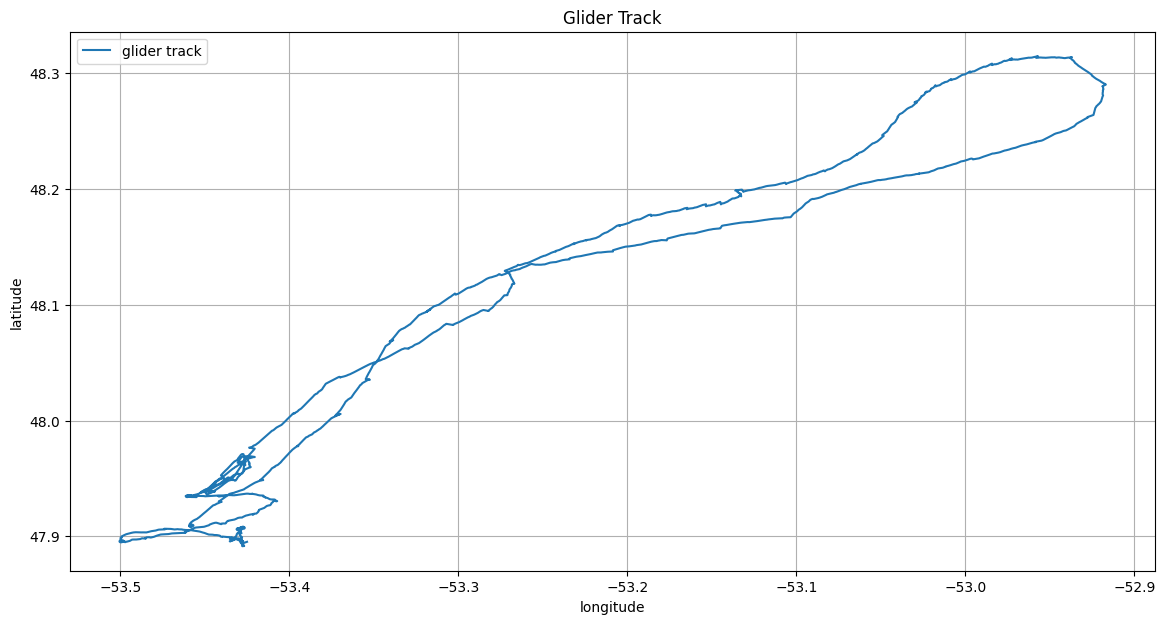

In [2]:
glider_data = '/Users/research/Documents/Glider_Projects/2022_TrinityBay_AZFP_Test/barnacle_20221120_deployment/nc_files/barnacle_trinity_bay_mission_L1.nc'
gl = xr.open_dataset(glider_data,decode_times=False)

fig, ax = plt.subplots(figsize=(14.0, 7.0))
ax.plot(gl['lon'],gl['lat'],label='glider track')
ax.set(xlabel='longitude', ylabel='latitude',
       title='Glider Track')
ax.grid()
ax.legend()
fig.savefig("GliderTrack.png")
plt.show()


In [3]:
# CONVERT AZFP FILES
#savedir =  '/Users/research/Desktop/AZFP_GLIDER_PROJECT/barnacle_20221120_deployment/AZFP_files_202211/nc/'

azfp_file_path = '/Users/research/Documents/Glider_Projects/2022_TrinityBay_AZFP_Test/barnacle_20221120_deployment/AZFP_files_202211'
xml_file_path = '/Users/research/Documents/Glider_Projects/2022_TrinityBay_AZFP_Test/barnacle_20221120_deployment/AZFP_files_202211/azfp_xml_file/FakeAZFP.xml'    
fnames = sorted(glob.glob(azfp_file_path + '/22112122.01A'))


for fn in fnames:
    if os.stat(fn).st_size !=0:
        print('convert ' + fn)    
        print(xml_file_path,fn)
        ed = open_raw(fn, sonar_model='AZFP', xml_path=xml_file_path)
        print(ed)
        #ed.to_netcdf(save_path=savedir) # Commented out, but used to save the "ed" sonar file info into netcdf
 

#




#filenames = sorted(glob.glob(savedir + '/*.nc'))[35] # picking a random file in the list
#print(filenames)
#nf = Dataset(filenames, mode='r')
#bsc=nf.groups['Sonar'].groups['Beam_group1'].variables['backscatter_r']
#bsc.shape

#bsc_67 = bsc[0,:,:,0]  # 67.5 kHz channel
#bsc_120 = bsc[1,:,:,0] # 120 kHz Channel
#bsc_200 = bsc[2,:,:,0] # 200 kHz Channel
#bsc_455 = bsc[3,:,:,0] # 455 kHz Channel 
#fig1 = plt.figure(figsize=(10.0, 7.0))
#ax = plt.gca()
#ax.pcolor(bsc_455.transpose())
#ax.set_ylim([0, 2000])
#ax.invert_yaxis()
#fig1.savefig("Backscatter455_Check.png")

convert /Users/research/Documents/Glider_Projects/2022_TrinityBay_AZFP_Test/barnacle_20221120_deployment/AZFP_files_202211/22112122.01A
/Users/research/Documents/Glider_Projects/2022_TrinityBay_AZFP_Test/barnacle_20221120_deployment/AZFP_files_202211/azfp_xml_file/FakeAZFP.xml /Users/research/Documents/Glider_Projects/2022_TrinityBay_AZFP_Test/barnacle_20221120_deployment/AZFP_files_202211/22112122.01A
<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data.
└── Vendor_specific: contains vend

azfp file ping= 1669068331 glider time= 1668946133.296
[131653 131654 131655 ... 135531 135532 135533]
Found NaNs in time data at indices. Removing these entries.


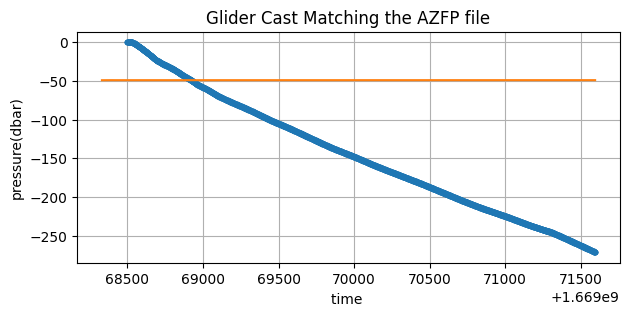

In [4]:
# Figure out the glider data that pertains to the AZFP file record
# Changing the xarray time to unix to index with the glider data
azfp_time = ed.beam.ping_time.data.astype('datetime64[s]').astype('uint32')
azfp_pres = ed.environment.temperature.values
glider_time = gl.time_unix.data


# See the unix time stamps
print('azfp file ping=',azfp_time[0],'glider time=',glider_time[0])

# we can now querry the glider data
gl_idx = np.argwhere(np.logical_and(glider_time>=azfp_time[0], glider_time<=azfp_time[-1])).flatten()
print(gl_idx)
# AZFP co-located T, S, P data from the glider
T = (gl.temperature.data)[gl_idx]
S = (gl.salinity.data)[gl_idx]
P = (gl.pressure.data)[gl_idx]
ProfIdx = (gl.profile_index)[gl_idx]

C = (1448.96 + 4.591 * T - 5.304e-2 * T**2 + 2.374e-4 * T**3 +
         1.340 * (S - 35) + 1.630e-2 * P + 1.675e-7 * P**2 -
         1.025e-2 * T * (S - 35) - 7.139e-13 * T * P**3)

glider_time = glider_time[gl_idx]

nan_indices = np.argwhere(np.isnan(glider_time) | np.isnan(P))
if len(nan_indices) > 0:
    print(f"Found NaNs in time data at indices. Removing these entries.")
    T = np.delete(T, nan_indices)
    S = np.delete(S, nan_indices)
    P = np.delete(P, nan_indices)
    C = np.delete(C, nan_indices)
    ProfIdx = np.delete(ProfIdx, nan_indices)
    glider_time = np.delete(glider_time, nan_indices)


# Great it matches - we go a downcast which is the only time we used the AZFP! 
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(glider_time[:], -P[:],'.')
ax.plot(azfp_time[:],azfp_pres)
ax.set(xlabel='time ', ylabel='pressure(dbar)', title='Glider Cast Matching the AZFP file')
ax.grid()
fig.savefig("GliderCastSegment.png")
plt.show()

In [5]:
# now need to use the echopype function to calibrate the backscatter group values in the "ed" object
env_params = {
    'temperature': np.nanmean(T),   # temperature in degree Celsius
    'salinity': np.nanmean(S),     # salinity in PSU
    'pressure': np.nanmean(P),     # pressure in dbar
    'sound_speed': np.nanmean(C)
}
ed

ds_Sv = ep.calibrate.compute_Sv(ed,env_params=env_params)

In [36]:
# Remove noise
ds_Sv = ep.clean.remove_noise(    # obtain a denoised Sv dataset
    ds_Sv,                # calibrated Sv dataset
    range_sample_num=10,  # number of samples along the range_sample dimension for estimating noise
    ping_num=1,           # number of pings for estimating noise
)

In [37]:
# Reduce data based on physical units
# Reduce data based on sample number
ds_Sv_gridded = ep.commongrid.compute_MVBS(
    ds_Sv,                # calibrated Sv dataset
    range_meter_bin=0.1,  # bin size to average along echo_range in meters
)

/Users/research/Venvs/echopype/lib/python3.11/site-packages/echopype/commongrid/mvbs.py:402: RuntimeWarning: Mean of empty slice
  final[bin_time - 1, :] = np.nanmean(er_means[:, indices], axis=1)
/Users/research/Venvs/echopype/lib/python3.11/site-packages/echopype/commongrid/mvbs.py:402: RuntimeWarning: Mean of empty slice
  final[bin_time - 1, :] = np.nanmean(er_means[:, indices], axis=1)
/Users/research/Venvs/echopype/lib/python3.11/site-packages/echopype/commongrid/mvbs.py:402: RuntimeWarning: Mean of empty slice
  final[bin_time - 1, :] = np.nanmean(er_means[:, indices], axis=1)
/Users/research/Venvs/echopype/lib/python3.11/site-packages/echopype/commongrid/mvbs.py:402: RuntimeWarning: Mean of empty slice
  final[bin_time - 1, :] = np.nanmean(er_means[:, indices], axis=1)


In [31]:
ds_Sv_gridded

<xarray.Dataset>
Dimensions:            (channel: 4, ping_time: 164, echo_range: 606)
Coordinates:
  * channel            (channel) <U11 '59023-67-1' ... '59023-455-4'
  * ping_time          (ping_time) datetime64[ns] 2022-11-21T22:05:20 ... 202...
  * echo_range         (echo_range) float64 0.0 0.25 0.5 ... 150.8 151.0 151.2
Data variables:
    Sv                 (channel, ping_time, echo_range) float64 -59.39 ... -3...
    frequency_nominal  (channel) float64 6.7e+04 1.2e+05 2e+05 4.55e+05
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.8.1
    processing_time:              2023-10-24T17:10:47Z
    processing_function:          commongrid.compute_MVBS

In [38]:
print(ds_Sv_gridded.echo_range.shape,ds_Sv_gridded.ping_time.shape)

(1515,) (164,)


In [39]:
# Interpolate glider time series to  ping time series
idx = np.argwhere(np.unique(P[~np.isnan(P)])).flatten()
glider_time_unix = glider_time

ping_time_unix = (ds_Sv_gridded.ping_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

# Ensure it's in the correct type (float or int), as np.interp requires
ping_time_unix = ping_time_unix.astype(np.float64)


# Interpolate using the POSIX timestamps
pressure_glider = P;
pressure_azfp = np.interp(ping_time_unix,glider_time_unix[idx],pressure_glider[idx])

[notX,y]=np.meshgrid(ping_time_unix,ds_Sv_gridded.echo_range)

y = y+pressure_azfp
[x,notY]=np.meshgrid(ds_Sv_gridded.ping_time,ds_Sv_gridded.echo_range)

print(ds_Sv_gridded.echo_range.shape)
print(pressure_azfp.shape)
print(y.shape)
#plt.plot(glider_time_unix,P)
#plt.plot(ping_time_unix,pressure_azfp)


(1515,)
(164,)
(1515, 164)


/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_47003/3380512088.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  ping_time_unix = (ds_Sv_gridded.ping_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')


(1515, 164) (1515, 164) (164, 1515)


/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_47003/150696894.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(x,-y,SV_64kHz.transpose())


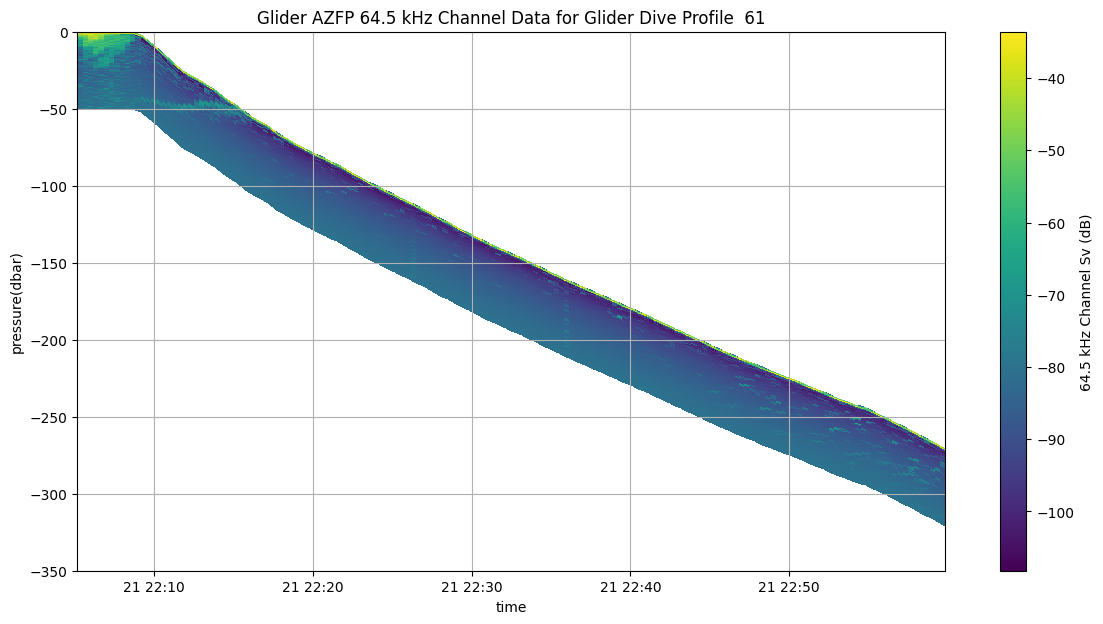

In [47]:
from datetime import datetime
import time
import matplotlib.dates as mdates

SV_64kHz=ds_Sv_gridded.Sv[0,:,:].values # 64.5 kHz

print(x.shape,y.shape,SV_64kHz.shape)

if np.ma.isMaskedArray(x):
    x = x.filled(np.nan)  # choose a fill value appropriate for your data
if np.ma.isMaskedArray(y):
    y = y.filled(np .nan)  # choose a fill value appropriate for your data

# Check for non-finite values and handle them as needed
#x = np.nan_to_num(x, nan=-9999)  # Replace nan with a specific number, here -9999
#y = np.nan_to_num(y, nan=-9999)  # Replace nan with a specific number, here -9999
SV_64kHz = np.nan_to_num(SV_64kHz, nan=np.nan)  # Replace nan with a specific number, here -9999

# Now create your plot
f = plt.figure(figsize=(14,7))
ax = f.add_subplot(111)

# Use 'nearest' shading to allow X, Y, and C to have the same dimensions
mesh = ax.pcolormesh(x,-y,SV_64kHz.transpose())

median_profile_idx = np.nanmedian(ProfIdx)

ax.set(xlabel='time', ylabel='pressure(dbar)', 
       title=f'Glider AZFP 64.5 kHz Channel Data for Glider Dive Profile  {median_profile_idx:.0f}')
ax.grid()
ax.set_ylim(-350, 0)

plt.colorbar(mesh, ax=ax, label="64.5 kHz Channel Sv (dB)")
f.savefig("GliderAZFP_Segment.png")
plt.show()


There is a lot more context provided here: https://echopype.readthedocs.io/en/stable/process.html